<a href="https://colab.research.google.com/github/thara-1996/computer_vision/blob/main/Exersice_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!unzip CIFAR10-small.zip

Streaming output truncated to the last 5000 lines.
  inflating: testing/image_0001.png  
  inflating: testing/image_0002.png  
  inflating: testing/image_0003.png  
  inflating: testing/image_0004.png  
  inflating: testing/image_0005.png  
  inflating: testing/image_0006.png  
  inflating: testing/image_0007.png  
  inflating: testing/image_0008.png  
  inflating: testing/image_0009.png  
  inflating: testing/image_0010.png  
  inflating: testing/image_0011.png  
  inflating: testing/image_0012.png  
  inflating: testing/image_0013.png  
  inflating: testing/image_0014.png  
  inflating: testing/image_0015.png  
  inflating: testing/image_0016.png  
  inflating: testing/image_0017.png  
  inflating: testing/image_0018.png  
  inflating: testing/image_0019.png  
  inflating: testing/image_0020.png  
  inflating: testing/image_0021.png  
  inflating: testing/image_0022.png  
  inflating: testing/image_0023.png  
  inflating: testing/image_0024.png  
  inflating: testing/image_0025.png  

Validation set size (2000, 32, 32, 3)
Test set size: (3000, 32, 32, 3)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1828 - loss: 2.2746 - val_accuracy: 0.2705 - val_loss: 2.0576
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2904 - loss: 2.0236 - val_accuracy: 0.3080 - val_loss: 1.9711
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3337 - loss: 1.9280 - val_accuracy: 0.3265 - val_loss: 1.9286
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3496 - loss: 1.8879 - val_accuracy: 0.3385 - val_loss: 1.9000
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3517 - loss: 1.8771 - val_accuracy: 0.3465 - val_loss: 1.8813
Test loss: 1.853091835975647
Test accuracy: 0.36033332347869873


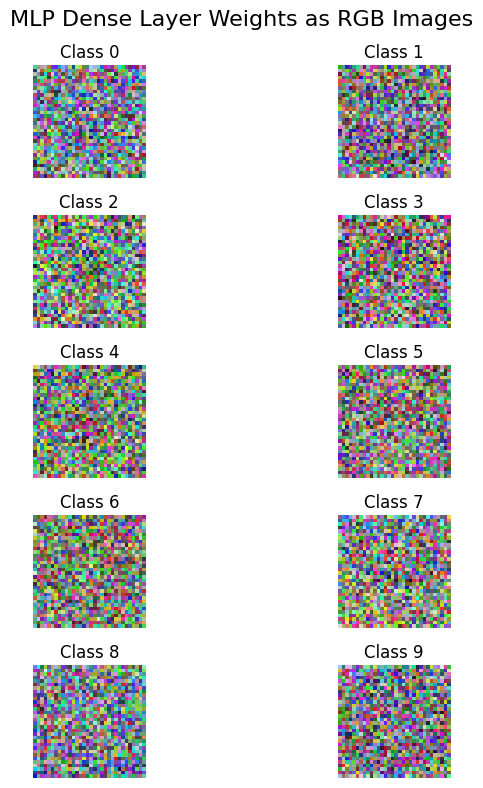

[[ 0.  0.  1.  2.]
 [ 0.  0.  1.  2.]
 [10. 15. 20. 30.]
 [ 0.  0.  0.  0.]]


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras import regularizers
from PIL import Image

def create_model(input_shape, dense_size, classes):
    x = Input(shape=(input_shape))
    y = Flatten()(x)
    y = Dense(classes, activation='softmax', name='dense_layer')(y)
    model = Model(inputs=x, outputs=y)
    return model

def load_labels(filename):
    with open(filename,'r') as file:
       li = file.readlines()
    label_count = len(li)
    labels = np.empty((label_count,1), dtype='int')
    i = 0
    with open(filename) as f:
        for line in f:
            labels[i] = int(line.replace("\n", ""))
            i = i + 1
    return labels

def load_images(folder, image_count, image_size):
    array_shape = (image_count, image_size[0], image_size[1], image_size[2])
    imageset = np.empty(array_shape, dtype='float')
    for i in range(0,image_count):
        image = Image.open(folder + '/image_' + "{:04d}".format(i) + '.png')
        imageset[i] = np.asarray(image)
    return imageset

def normalize_dataset(sampled_images):
	sampled_images = (sampled_images.astype('float32')-128) / 128
	return sampled_images

def split_test_val(data, splitpoint):
    return data[splitpoint:], data[:splitpoint]

########################################################################
Y_test = load_labels('testing/labels.csv')
X_test = load_images('testing', len(Y_test), (32,32,3))

y_train = load_labels('training/labels.csv')
x_train = load_images('training', len(y_train), (32,32,3))

x_train = normalize_dataset(x_train)

##### Test set preparation #####
splitpoint = 2000
X_test = normalize_dataset(X_test)
x_test, x_val = split_test_val(X_test, splitpoint)
y_test, y_val = split_test_val(Y_test, splitpoint)
print('Validation set size', x_val.shape)
print('Test set size:', x_test.shape)
print('')

class_count = len(np.unique(y_train))

# define a neural network for training
dims = (32, 32, 3)
dense_sz = 100
model = create_model(dims, dense_sz, class_count)

model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

from matplotlib import pyplot as plt
weights, biases = model.get_layer('dense_layer').get_weights()
height, width, channels = 32, 32, 3
input_shape = (height, width, channels)

fig, axes = plt.subplots(5, 2, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
  if i >= weights.shape[1]:
    break

  weight_vector = weights[:, i]
  weight_image = weight_vector.reshape(input_shape)

  min_val = weight_image.min()
  max_val = weight_image.max()
  weight_image = (weight_image - min_val) / (max_val - min_val + 1e-5) # Avoid division by 0

  ax.imshow(weight_image)
  ax.set_title(f'Class {i}')
  ax.axis('off')

plt.suptitle('MLP Dense Layer Weights as RGB Images', fontsize=16)
plt.tight_layout()
plt.show()
import numpy as np
from tensorflow import keras

input = np.array([[-1, 0, 1, 2], [-2, 0, 1, 2], [10, 15, 20, 30], [-20, -10, -5, -1]]).astype(np.float32)

output = keras.activations.relu(input)

print(output.numpy())




Validation set size (2000, 32, 32, 3)
Test set size: (3000, 32, 32, 3)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1643 - loss: 2.3287 - val_accuracy: 0.2745 - val_loss: 2.0397
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2863 - loss: 2.0109 - val_accuracy: 0.3175 - val_loss: 1.9514
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3236 - loss: 1.9304 - val_accuracy: 0.3390 - val_loss: 1.9078
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3429 - loss: 1.8994 - val_accuracy: 0.3510 - val_loss: 1.8799
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3533 - loss: 1.8661 - val_accuracy: 0.3595 - val_loss: 1.8643
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3701 - loss: 1.8378 - val_accuracy: 0.3645 - val_loss: 1.8498
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3697 - loss: 1.8442 - val_accuracy: 0.3690 - val_loss: 1.8398
Epoch 8/100
313/313 ━━━━━

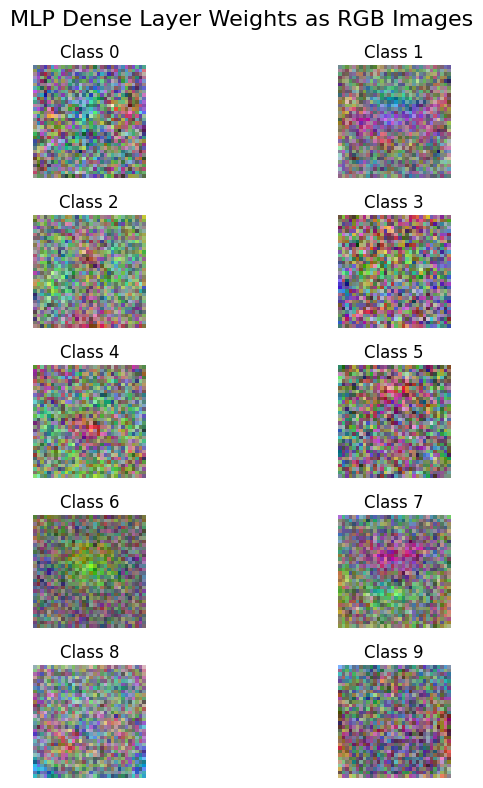

[[ 0.  0.  1.  2.]
 [ 0.  0.  1.  2.]
 [10. 15. 20. 30.]
 [ 0.  0.  0.  0.]]


In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras import regularizers
from PIL import Image

def create_model(input_shape, dense_size, classes):
    x = Input(shape=(input_shape))
    y = Flatten()(x)
    y = Dense(classes, activation='softmax', name='dense_layer')(y)
    model = Model(inputs=x, outputs=y)
    return model

def load_labels(filename):
    with open(filename,'r') as file:
       li = file.readlines()
    label_count = len(li)
    labels = np.empty((label_count,1), dtype='int')
    i = 0
    with open(filename) as f:
        for line in f:
            labels[i] = int(line.replace("\n", ""))
            i = i + 1
    return labels

def load_images(folder, image_count, image_size):
    array_shape = (image_count, image_size[0], image_size[1], image_size[2])
    imageset = np.empty(array_shape, dtype='float')
    for i in range(0,image_count):
        image = Image.open(folder + '/image_' + "{:04d}".format(i) + '.png')
        imageset[i] = np.asarray(image)
    return imageset

def normalize_dataset(sampled_images):
	sampled_images = (sampled_images.astype('float32')-128) / 128
	return sampled_images

def split_test_val(data, splitpoint):
    return data[splitpoint:], data[:splitpoint]

########################################################################
Y_test = load_labels('testing/labels.csv')
X_test = load_images('testing', len(Y_test), (32,32,3))

y_train = load_labels('training/labels.csv')
x_train = load_images('training', len(y_train), (32,32,3))

x_train = normalize_dataset(x_train)

##### Test set preparation #####
splitpoint = 2000
X_test = normalize_dataset(X_test)
x_test, x_val = split_test_val(X_test, splitpoint)
y_test, y_val = split_test_val(Y_test, splitpoint)
print('Validation set size', x_val.shape)
print('Test set size:', x_test.shape)
print('')

class_count = len(np.unique(y_train))

# define a neural network for training
dims = (32, 32, 3)
dense_sz = 100
model = create_model(dims, dense_sz, class_count)

model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), metrics=['accuracy'])
model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

from matplotlib import pyplot as plt
weights, biases = model.get_layer('dense_layer').get_weights()
height, width, channels = 32, 32, 3
input_shape = (height, width, channels)

fig, axes = plt.subplots(5, 2, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
  if i >= weights.shape[1]:
    break

  weight_vector = weights[:, i]
  weight_image = weight_vector.reshape(input_shape)

  min_val = weight_image.min()
  max_val = weight_image.max()
  weight_image = (weight_image - min_val) / (max_val - min_val + 1e-5) # Avoid division by 0

  ax.imshow(weight_image)
  ax.set_title(f'Class {i}')
  ax.axis('off')

plt.suptitle('MLP Dense Layer Weights as RGB Images', fontsize=16)
plt.tight_layout()
plt.show()
import numpy as np
from tensorflow import keras

input = np.array([[-1, 0, 1, 2], [-2, 0, 1, 2], [10, 15, 20, 30], [-20, -10, -5, -1]]).astype(np.float32)

output = keras.activations.relu(input)

print(output.numpy())


